# Pan005 temp transects

In [1]:
import dask.distributed as dsk
import glob
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40207/status,
Dashboard: /proxy/40207/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36497,Workers: 28
Dashboard: /proxy/40207/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:41883,Total threads: 1
Dashboard: /proxy/36893/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:33933,


In [4]:
# Import the data
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))[-120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/outpu*/*.ocean_month_z.nc'))[:60]

In [5]:
# Shelf mask
shelf_mask = shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc')['contour_masked_above']

In [6]:
def preprocess(ds):
    ds = ds[['thetao','so']].sel(yh=slice(-79,-62))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [7]:
## Time slicing
# Taking last 5 years 
cont = cont.sel(time=slice('2006-01-01','2010-12-31'))
melt = melt.sel(time=slice('2006-01-01','2010-12-31'))

In [8]:
tempC = cont['thetao']
tempM = melt['thetao']

In [9]:
saltC = cont['so']
saltM = melt['so']

### The transects I will take:

I am wanting transects from different regimes, as per the Moorman paper.   
So, I am using:
- 135 W
- 165 W
- 260 W
- 65 E

In [10]:
import gsw

### 135 W: Warm regime

In [11]:
cont_135W = cont.sel(xh='-135',method='nearest').mean('time')
melt_135W = melt.sel(xh='-135',method='nearest').mean('time')
cont_135W

<xarray.Dataset> Size: 485kB
Dimensions:  (z_l: 75, yh: 797)
Coordinates:
    xh       float64 8B -135.0
  * yh       (yh) float64 6kB -78.99 -78.96 -78.94 ... -62.07 -62.04 -62.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Data variables:
    thetao   (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>
    so       (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>

In [12]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_135W['z_l'], cont_135W['yh'])
p_melt = gsw.p_from_z(-melt_135W['z_l'], melt_135W['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_135W['so'], p_cont, cont_135W['xh'], cont_135W['yh'])
SA_melt =  gsw.SA_from_SP(melt_135W['so'], p_melt, melt_135W['xh'], melt_135W['yh'])

# Calculating conservative temperature
temp_135W_C = gsw.CT_from_pt(SA_cont,cont_135W['thetao'])
temp_135W_M = gsw.CT_from_pt(SA_melt,melt_135W['thetao'])

In [13]:
temp_135W_anom = temp_135W_M - temp_135W_C
temp_135W_anom

<xarray.DataArray 'so' (z_l: 75, yh: 797)> Size: 478kB
dask.array<sub, shape=(75, 797), dtype=float64, chunksize=(75, 276), chunktype=numpy.ndarray>
Coordinates:
    xh       float64 8B -135.0
  * yh       (yh) float64 6kB -78.99 -78.96 -78.94 ... -62.07 -62.04 -62.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [14]:
# To fix the label issues
temp_135W_anom = xr.DataArray(temp_135W_anom, dims=cont_135W['thetao'].dims, coords=cont_135W['thetao'].coords)
temp_135W_anom.attrs['units'] = '°C'
temp_135W_anom.name = 'CT'

In [15]:
temp_135W_anom.load()

<xarray.DataArray 'CT' (z_l: 75, yh: 797)> Size: 478kB
array([[       nan,        nan,        nan, ..., 0.11542835, 0.11423907,
        0.11155757],
       [       nan,        nan,        nan, ..., 0.115776  , 0.11460451,
        0.11189233],
       [       nan,        nan,        nan, ..., 0.11584423, 0.11466379,
        0.11196513],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
    xh       float64 8B -135.0
  * yh       (yh) float64 6kB -78.99 -78.96 -78.94 ... -62.07 -62.04 -62.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Attributes:
    units:    °C

In [16]:
temp_135W_anom_new = temp_135W_anom.sel(z_l=slice(0,1500)).sel(yh=slice(-75,-72))
temp_135W_anom_new = temp_135W_anom_new.load()

Text(0.5, 1.0, 'Pan005 temperature anomaly at 135°W')

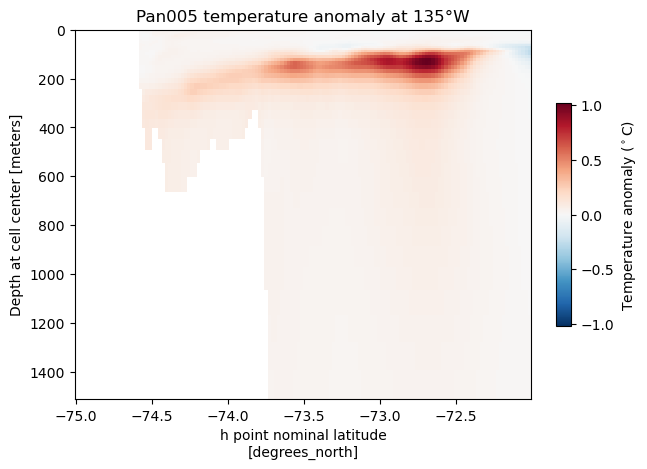

In [17]:
temp_135W_anom_new.plot(cbar_kwargs={"label": "Temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7})
plt.gca().invert_yaxis()
plt.title("Pan005 temperature anomaly at 135°W")


### 165 W: Cool regime

In [18]:
cont_165W = cont.sel(xh='-165',method='nearest').mean('time')
melt_165W = melt.sel(xh='-165',method='nearest').mean('time')
cont_165W

<xarray.Dataset> Size: 485kB
Dimensions:  (z_l: 75, yh: 797)
Coordinates:
    xh       float64 8B -165.0
  * yh       (yh) float64 6kB -78.99 -78.96 -78.94 ... -62.07 -62.04 -62.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Data variables:
    thetao   (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>
    so       (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>

In [19]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_165W['z_l'], cont_165W['yh'])
p_melt = gsw.p_from_z(-melt_165W['z_l'], melt_165W['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_165W['so'], p_cont, cont_165W['xh'], cont_165W['yh'])
SA_melt =  gsw.SA_from_SP(melt_165W['so'], p_melt, melt_165W['xh'], melt_165W['yh'])

# Calculating conservative temperature
temp_165W_C = gsw.CT_from_pt(SA_cont,cont_165W['thetao'])
temp_165W_M = gsw.CT_from_pt(SA_melt,melt_165W['thetao'])

In [20]:
temp_165W_anom = temp_165W_M - temp_165W_C
temp_165W_anom

<xarray.DataArray 'so' (z_l: 75, yh: 797)> Size: 478kB
dask.array<sub, shape=(75, 797), dtype=float64, chunksize=(75, 276), chunktype=numpy.ndarray>
Coordinates:
    xh       float64 8B -165.0
  * yh       (yh) float64 6kB -78.99 -78.96 -78.94 ... -62.07 -62.04 -62.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [21]:
# To fix the label issues
temp_165W_anom = xr.DataArray(temp_165W_anom, dims=cont_165W['thetao'].dims, coords=cont_165W['thetao'].coords)
temp_165W_anom.attrs['units'] = '°C'
temp_165W_anom.name = 'CT'

In [22]:
temp_165W_anom = temp_165W_anom.load()

In [23]:
temp_165W_anom_new = temp_165W_anom.sel(z_l=slice(0,1500)).sel(yh=slice(-79,-75))
temp_165W_anom_new = temp_165W_anom_new.load()

Text(0.5, 1.0, 'Pan005 temperature anomaly at 165°W')

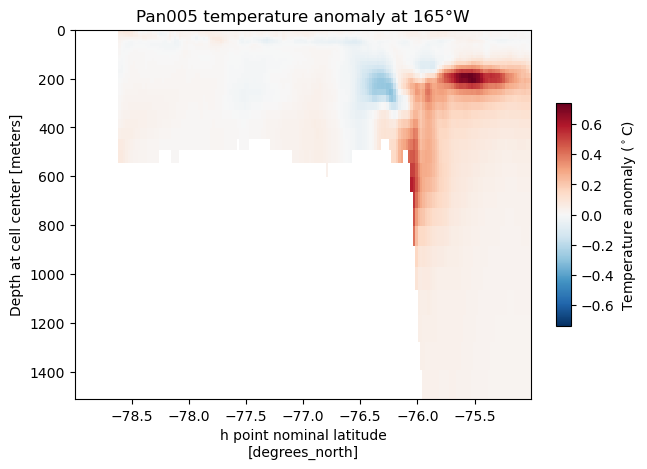

In [24]:
temp_165W_anom_new.plot(cbar_kwargs={"label": "Temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7})
plt.gca().invert_yaxis()
plt.title("Pan005 temperature anomaly at 165°W")



### 260W: Fresh regime

In [25]:
cont_260W = cont.sel(xh='-260',method='nearest').mean('time')
melt_260W = melt.sel(xh='-260',method='nearest').mean('time')
cont_260W

<xarray.Dataset> Size: 485kB
Dimensions:  (z_l: 75, yh: 797)
Coordinates:
    xh       float64 8B -260.0
  * yh       (yh) float64 6kB -78.99 -78.96 -78.94 ... -62.07 -62.04 -62.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Data variables:
    thetao   (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>
    so       (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>

In [26]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_260W['z_l'], cont_260W['yh'])
p_melt = gsw.p_from_z(-melt_260W['z_l'], melt_260W['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_260W['so'], p_cont, cont_260W['xh'], cont_260W['yh'])
SA_melt =  gsw.SA_from_SP(melt_260W['so'], p_melt, melt_260W['xh'], melt_260W['yh'])

# Calculating conservative temperature
temp_260W_C = gsw.CT_from_pt(SA_cont,cont_260W['thetao'])
temp_260W_M = gsw.CT_from_pt(SA_melt,melt_260W['thetao'])

In [27]:
temp_260W_anom = temp_260W_M - temp_260W_C

# To fix the label issues
temp_260W_anom = xr.DataArray(temp_260W_anom, dims=cont_260W['thetao'].dims, coords=cont_260W['thetao'].coords)
temp_260W_anom.attrs['units'] = '°C'
temp_260W_anom.name = 'CT'

temp_260W_anom

<xarray.DataArray 'CT' (z_l: 75, yh: 797)> Size: 478kB
dask.array<sub, shape=(75, 797), dtype=float64, chunksize=(75, 276), chunktype=numpy.ndarray>
Coordinates:
    xh       float64 8B -260.0
  * yh       (yh) float64 6kB -78.99 -78.96 -78.94 ... -62.07 -62.04 -62.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Attributes:
    units:    °C

In [28]:
temp_260W_anom = temp_260W_anom.load()

In [29]:
temp_260W_anom_new = temp_260W_anom.sel(z_l=slice(0,1500)).sel(yh=slice(-66,-62.5))
temp_260W_anom_new = temp_260W_anom_new.load()

Text(0.5, 1.0, 'Pan005 temperature anomaly at 260°W')

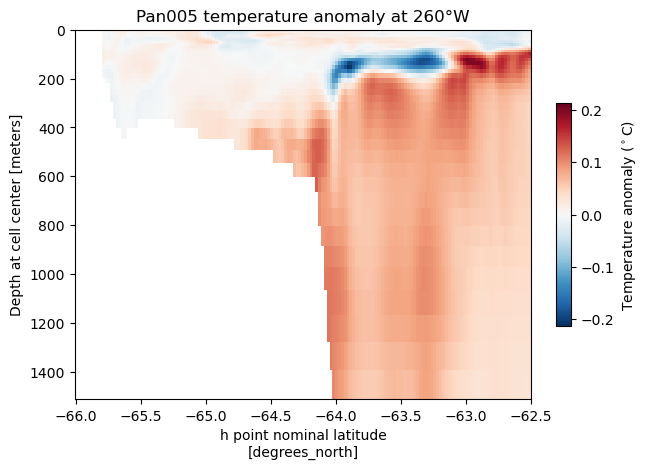

In [30]:
temp_260W_anom_new.plot(cbar_kwargs={"label": "Temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7})
plt.gca().invert_yaxis()
plt.title("Pan005 temperature anomaly at 260°W")



### 65 E: Dense regime

In [31]:
cont_65E = cont.sel(xh='65',method='nearest').mean('time')
melt_65E = melt.sel(xh='65',method='nearest').mean('time')
cont_65E

<xarray.Dataset> Size: 485kB
Dimensions:  (z_l: 75, yh: 797)
Coordinates:
    xh       float64 8B 65.02
  * yh       (yh) float64 6kB -78.99 -78.96 -78.94 ... -62.07 -62.04 -62.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Data variables:
    thetao   (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>
    so       (z_l, yh) float32 239kB dask.array<chunksize=(75, 464), meta=np.ndarray>

In [32]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont_65E['z_l'], cont_65E['yh'])
p_melt = gsw.p_from_z(-melt_65E['z_l'], melt_65E['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont_65E['so'], p_cont, cont_65E['xh'], cont_65E['yh'])
SA_melt =  gsw.SA_from_SP(melt_65E['so'], p_melt, melt_65E['xh'], melt_65E['yh'])

# Calculating conservative temperature
temp_65E_C = gsw.CT_from_pt(SA_cont,cont_65E['thetao'])
temp_65E_M = gsw.CT_from_pt(SA_melt,melt_65E['thetao'])

In [33]:
temp_65E_anom = temp_65E_M - temp_65E_C

# To fix the label issues
temp_65E_anom = xr.DataArray(temp_65E_anom, dims=cont_65E['thetao'].dims, coords=cont_65E['thetao'].coords)
temp_65E_anom.attrs['units'] = '°C'
temp_65E_anom.name = 'CT'

temp_65E_anom

<xarray.DataArray 'CT' (z_l: 75, yh: 797)> Size: 478kB
dask.array<sub, shape=(75, 797), dtype=float64, chunksize=(75, 276), chunktype=numpy.ndarray>
Coordinates:
    xh       float64 8B 65.02
  * yh       (yh) float64 6kB -78.99 -78.96 -78.94 ... -62.07 -62.04 -62.02
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Attributes:
    units:    °C

In [34]:
temp_65E_anom = temp_65E_anom.load()

In [35]:
temp_65E_anom_new = temp_65E_anom.sel(z_l=slice(0,1500)).sel(yh=slice(-68,-65))
temp_65E_anom_new = temp_65E_anom_new.load()

Text(0.5, 1.0, 'Pan005 temperature anomaly at 65°E')

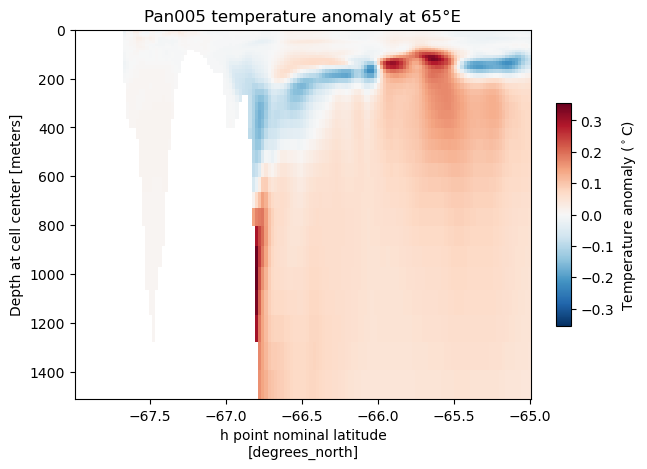

In [36]:
temp_65E_anom_new.plot(cbar_kwargs={"label": "Temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7})
plt.gca().invert_yaxis()
plt.title("Pan005 temperature anomaly at 65°E")

